In [1]:
import pandas as pd
import ast
import numpy as np

In [2]:
from server_config import DATA_PATH
from ML_Pipeline import  MatchConfig, run_pipeline


### 1. Therapist data

In [3]:
df_th = pd.read_csv(DATA_PATH + "/df_th_nopr_experience_corrected_200624_LB.csv", sep=";",low_memory = "False")

In [4]:
keep_cols_th = ['therapist_id', 't0_method_t_CBT','t0_method_t_PDT','t0_method_t_ST','t0_method_t_AP', 't0_appliedmethod_t_VT', 't0_appliedmethod_t_TP',
             't0_appliedmethod_t_AP', 't0_appliedmethod_t_ST','t0_appliedmethod_t_Other','t0_location_t','t0_gender_t',
 't0_relationship_t','t0_sexualorientation_t','t0_children_t','t0_age_t', 't0_experience_t','t0_license_t', 't0_bfi_t_1',
 't0_bfi_t_2','t0_bfi_t_3','t0_bfi_t_4','t0_bfi_t_5','t0_bfi_t_6','t0_bfi_t_7','t0_bfi_t_8','t0_bfi_t_9','t0_bfi_t_10',]

In [5]:
labels = ["VT", "TP", "AP", "ST", "Other"]  

col = df_th["t0_appliedmethod_t_A"]

# 1) Parse strings like "[True, False, ...]" -> list
col = col.map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 2) Unwrap nested lists like [[True, False, ...]] -> [True, False, ...]
col = col.map(lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) == 1 and isinstance(x[0], (list, tuple)) else x)

# 3) Safety: replace missing/invalid with all-False (or raise if you prefer)
def ensure_five(x):
    if isinstance(x, (list, tuple)) and len(x) == 5:
        return list(x)
    if pd.isna(x):
        return [False]*5

col = col.map(ensure_five)

# 4) Build the indicator columns
method_df = (
    pd.DataFrame(col.tolist(), index=df_th.index, columns=labels)
      .astype(int)
      .add_prefix("t0_appliedmethod_t_")
)

In [6]:
df_th = df_th.join(method_df)


In [7]:
df_th = df_th[keep_cols_th]

In [8]:
# BFI-10 items (1–5), reverse-code, then build subscale SUMS using df_th and t0-prefix
bfi_items = [f"t0_bfi_t_{i}" for i in range(1, 11)]
df_th[bfi_items] = df_th[bfi_items].apply(pd.to_numeric, errors="coerce")


# Subscale sums (2 items each)
df_th["t0_bfi_t_extraversion"]     = df_th[["t0_bfi_t_1", "t0_bfi_t_6"]].sum(axis=1)
df_th["t0_bfi_t_agreeableness"]    = df_th[["t0_bfi_t_2",   "t0_bfi_t_7"]].sum(axis=1)
df_th["t0_bfi_t_conscientiousness"]= df_th[["t0_bfi_t_3", "t0_bfi_t_8"]].sum(axis=1)
df_th["t0_bfi_t_neuroticism"]      = df_th[["t0_bfi_t_4", "t0_bfi_t_9"]].sum(axis=1)
df_th["t0_bfi_t_openness"]         = df_th[["t0_bfi_t_5", "t0_bfi_t_10"]].sum(axis=1)




### 2. Patient data

In [9]:
df_pat = pd.read_json(DATA_PATH + "/TONI_pat_corrected_20241025_raw.json")

In [10]:
keep_cols = (
    # IDs / study
    ['patient_id', 'therapist_id', 'u_registrationDate_p'] +

    # Demographics / baseline
    ['t0_age_p','t0_gender_p','t0_school_p','t0_employment_p','t0_location_p'] +
    [f"t0_therapy_p_{i}" for i in range(1, 4)] +
    ['t0_familyhistory_p','t0_meds_p','t0_relationship_p','t0_ses_p'] +
    [f"t0_migration_p_{i}" for i in range(1, 4)] +
    [f"surveys.t0.answers.1585.discrimination_{i}" for i in range(1, 6)] +
    [f"t0_disease_p_{c}" for c in list('ABCDEFG')] +

    # t0 scales
    [f"t0_phq_p_{i}" for i in range(1, 9)] +
    [f"t0_gad_p_{i}" for i in range(1, 7+1)] +
    [f"t0_swls_p_{i}" for i in range(1, 5+1)] +
    [f"t0_aqol_p_{i}" for i in range(1, 35+1)] +
    [f"t0_ede_p_{i}" for i in range(1, 8+1)] +
    (['t0_audit_p_filter'] + [f"t0_audit_p_{i}" for i in range(1, 3+1)]) +
    (['t0_dudit_p_filter'] + [f"t0_dudit_p_{i}" for i in range(1, 4+1)]) +
    [f"t0_msfq_p_{i}" for i in range(1, 5+1)] +
    [f"t0_pid_p_{i}" for i in range(1, 36+1)] +
    [f"t0_opd_p_{i}" for i in range(1, 12+1)] +
    [f"t0_ace_p_{i}" for i in range(1, 10+1)] +
    [f"t0_ask_p_{i}" for i in range(1, 3+1)] +
    [f"t0_mhse_p_{i}" for i in range(1, 6+1)] +

    # t1 scales
    [f"t1_phq_p_{i}" for i in range(1, 8+1)] +
    [f"t1_gad_p_{i}" for i in range(1, 7+1)] +
    [f"t1_multi_p_{i}" for i in range(1, 7+1)] +


    # alliance / matching

    [ 't0_change_p_1', 't0_change_p_2', 't0_dropout_p']
)


In [11]:
df_pat= df_pat[keep_cols]

#### 2.1 Calculate Subscales for self-report data

#### Outcome (PHQ + GAD)

In [12]:
# define item columns
phq_cols_t1 = [f"t1_phq_p_{i}" for i in range(1, 9)]
gad_cols_t1 = [f"t1_gad_p_{i}" for i in range(1, 8)]

mask_complete = df_pat[phq_cols_t1 + gad_cols_t1].notna().all(axis=1)
df_pat_clean = df_pat.loc[mask_complete].copy()

In [13]:
df_pat_clean["t1_phq8_total"] = df_pat_clean[phq_cols_t1].sum(axis=1)
df_pat_clean["t1_gad7_total"] = df_pat_clean[gad_cols_t1].sum(axis=1)

In [14]:
df_pat_clean["t1_distress_sum"] = (
    df_pat_clean["t1_phq8_total"] + df_pat_clean["t1_gad7_total"]
)

In [15]:
# define item columns
phq_cols_t0 = [f"t0_phq_p_{i}" for i in range(1, 9)]
gad_cols_t0 = [f"t0_gad_p_{i}" for i in range(1, 8)]

In [16]:
df_pat_clean["t0_phq8_p_sum"] = df_pat_clean[phq_cols_t0].sum(axis=1)
df_pat_clean["t0_gad7_p_sum"] = df_pat_clean[gad_cols_t0].sum(axis=1)

In [17]:
df_pat_clean["t0_distress_sum"] = (
    df_pat_clean["t0_phq8_p_sum"] + df_pat_clean["t0_gad7_p_sum"]
)

In [18]:
df_pat_clean["change_distress"] =  df_pat_clean["t0_distress_sum"] - df_pat_clean["t1_distress_sum"] 

<Axes: >

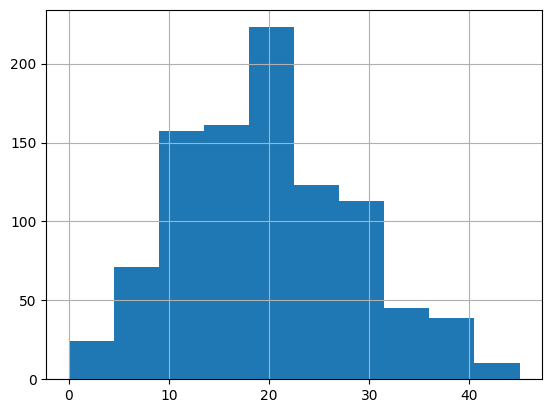

In [19]:
import matplotlib
df_pat_clean["t1_distress_sum"].hist()

<Axes: >

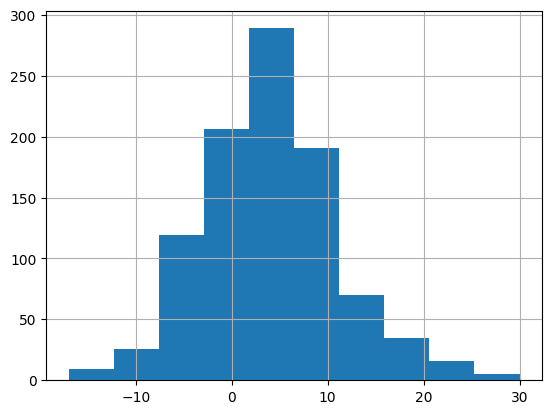

In [20]:
import matplotlib
df_pat_clean["change_distress"].hist()

In [21]:
df_pat_clean["change_distress"].describe()

count    966.000000
mean       3.963768
std        7.054762
min      -17.000000
25%       -1.000000
50%        3.500000
75%        8.000000
max       30.000000
Name: change_distress, dtype: float64

#### SWLS Baseline

In [22]:
swls_cols_t0 = [f"t0_swls_p_{i}" for i in range(1, 6)]

In [23]:
df_pat_clean["t0_swls_p_sum"] = df_pat_clean[swls_cols_t0].sum(axis=1)

#### Aqol Baseline

In [24]:
aqol_map = {
    "t0_aqol_p_coping": ['t0_aqol_p_1', 't0_aqol_p_21', 't0_aqol_p_29'],
    "t0_aqol_p_relationship": ['t0_aqol_p_2', 't0_aqol_p_4', 't0_aqol_p_9', 't0_aqol_p_10',
                               't0_aqol_p_23', 't0_aqol_p_31', 't0_aqol_p_34'],
    "t0_aqol_p_independent_living": ['t0_aqol_p_3', 't0_aqol_p_15', 't0_aqol_p_19', 't0_aqol_p_30'],
    "t0_aqol_p_mental_health": ['t0_aqol_p_5', 't0_aqol_p_8', 't0_aqol_p_12', 't0_aqol_p_14',
                                't0_aqol_p_16', 't0_aqol_p_18', 't0_aqol_p_33', 't0_aqol_p_35'],
    "t0_aqol_p_pain": ['t0_aqol_p_6', 't0_aqol_p_22', 't0_aqol_p_24'],
    "t0_aqol_p_self_worth": ['t0_aqol_p_7', 't0_aqol_p_13', 't0_aqol_p_26'],
    "t0_aqol_p_happiness": ['t0_aqol_p_17', 't0_aqol_p_20', 't0_aqol_p_25', 't0_aqol_p_27'],
    "t0_aqol_p_senses": ['t0_aqol_p_11', 't0_aqol_p_28', 't0_aqol_p_32'],
}

In [25]:
df_pat_clean = df_pat_clean.assign(**{scale: df_pat_clean[items].mean(axis=1) for scale, items in aqol_map.items()})


#### EDE Baseline

In [26]:
df_pat_clean["t0_ede_p_sum"] = df_pat_clean[[f"t0_ede_p_{i}" for i in range(1, 9)]].sum(axis=1)


#### Audit Baseline

In [27]:
aud_items = [f"t0_audit_p_{i}" for i in range(1, 5)]
fcol = "t0_audit_p_filter"

# set all AUDIT item columns to 0 if filter == 0
df_pat_clean.loc[df_pat_clean[fcol].eq(0), aud_items] = 0

# sum AUDIT items only if filter == 1; otherwise set total to 0
df_pat_clean["t0_audit_p_sum"] = np.where(
    df_pat_clean[fcol].eq(1),
    df_pat_clean[aud_items].sum(axis=1),
    0
)

#### Dudit Baseline

In [28]:
dud_items = [f"t0_dudit_p_{i}" for i in range(1, 5)]
fcol = "t0_dudit_p_filter"

# set all AUDIT item columns to 0 if filter == 0
df_pat_clean.loc[df_pat_clean[fcol].eq(0), dud_items] = 0

# sum AUDIT items only if filter == 1; otherwise set total to 0
df_pat_clean["t0_dudit_p_sum"] = np.where(
    df_pat_clean[fcol].eq(1),
    df_pat_clean[dud_items].sum(axis=1),
    0
)

#### MFSQ Baseline

In [29]:
msfq_cols = [f"t0_msfq_p_{i}" for i in range(1, 6)]
df_pat_clean[msfq_cols] = df_pat_clean[msfq_cols].apply(pd.to_numeric, errors="coerce")

df_pat_clean["t0_msfq_p_sum"] = df_pat_clean[msfq_cols].sum(axis=1)

#### PID5BF+ Baseline

In [30]:

# PID-5 BF+ domains → item columns
pid_map = {
    "t0_pid_p_negative_affect": ['t0_pid_p_1','t0_pid_p_7','t0_pid_p_13','t0_pid_p_19','t0_pid_p_25','t0_pid_p_31'],
    "t0_pid_p_antagonism":      ['t0_pid_p_2','t0_pid_p_8','t0_pid_p_14','t0_pid_p_20','t0_pid_p_26','t0_pid_p_32'],
    "t0_pid_p_disinhibition":   ['t0_pid_p_3','t0_pid_p_9','t0_pid_p_15','t0_pid_p_21','t0_pid_p_27','t0_pid_p_33'],
    "t0_pid_p_detachment":      ['t0_pid_p_4','t0_pid_p_10','t0_pid_p_16','t0_pid_p_22','t0_pid_p_28','t0_pid_p_34'],
    "t0_pid_p_psychoticism":    ['t0_pid_p_5','t0_pid_p_11','t0_pid_p_17','t0_pid_p_23','t0_pid_p_29','t0_pid_p_35'],
    "t0_pid_p_anankastia":      ['t0_pid_p_6','t0_pid_p_12','t0_pid_p_18','t0_pid_p_24','t0_pid_p_30','t0_pid_p_36'],
}

# 1) Coerce all PID item columns to numeric (e.g., "2" → 2, invalid → NaN)
item_cols = sorted({c for cols in pid_map.values() for c in cols})
df_pat_clean[item_cols] = df_pat_clean[item_cols].apply(pd.to_numeric, errors="coerce")

# 2) Domain sums (NaNs treated as 0 by default)
for scale, items in pid_map.items():
    df_pat_clean[scale] = df_pat_clean[items].mean(axis=1)


#### OPD Baseline

In [31]:
# OPD-SFK domains → item columns
opd_map = {
    "t0_opd_p_self":         ['t0_opd_p_1', 't0_opd_p_2', 't0_opd_p_5', 't0_opd_p_8'],
    "t0_opd_p_contact":      ['t0_opd_p_4', 't0_opd_p_6', 't0_opd_p_10', 't0_opd_p_11'],
    "t0_opd_p_relationship": ['t0_opd_p_3', 't0_opd_p_7', 't0_opd_p_9', 't0_opd_p_12'],
}

# coerce item columns to numeric (e.g., "2" → 2; invalid → NaN)
opd_items = sorted({c for cols in opd_map.values() for c in cols})
df_pat_clean[opd_items] = df_pat_clean[opd_items].apply(pd.to_numeric, errors="coerce")

# domain sums (NaNs treated as 0 by default)
for scale, items in opd_map.items():
    df_pat_clean[scale] = df_pat_clean[items].mean(axis=1)

#### ACE Baseline

In [32]:
ace_cols = [f"t0_ace_p_{i}" for i in range(1, 11)]

# ensure numeric (e.g., "1" -> 1; invalid -> NaN)
df_pat_clean[ace_cols] = df_pat_clean[ace_cols].apply(pd.to_numeric, errors="coerce")

df_pat_clean["t0_ace_p_sum"] = df_pat_clean[ace_cols].sum(axis=1)

/tmp/ipykernel_1834060/1448277295.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pat_clean["t0_ace_p_sum"] = df_pat_clean[ace_cols].sum(axis=1)


#### ASK Baseline

In [33]:
ask_cols = [f"t0_ask_p_{i}" for i in range(1, 4)]
df_pat_clean[ask_cols] = df_pat_clean[ask_cols].apply(pd.to_numeric, errors="coerce")

df_pat_clean["t0_ask_p_sum"] = df_pat_clean[ask_cols].sum(axis=1)

/tmp/ipykernel_1834060/3480057311.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pat_clean["t0_ask_p_sum"] = df_pat_clean[ask_cols].sum(axis=1)


#### MHSE Baseline

In [34]:
mhse_cols = [f"t0_mhse_p_{i}" for i in range(1, 7)]
df_pat_clean[mhse_cols] = df_pat_clean[mhse_cols].apply(pd.to_numeric, errors="coerce")

df_pat_clean["t0_mhse_p_sum"] = df_pat_clean[mhse_cols].sum(axis=1)

/tmp/ipykernel_1834060/913225046.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pat_clean["t0_mhse_p_sum"] = df_pat_clean[mhse_cols].sum(axis=1)


#### Multi T1

In [35]:
# define the 7 MULTI item columns once
multi_cols = [f"t1_multi_p_{i}" for i in range(1, 8)]

# 1) ensure the same columns are numeric
df_pat_clean[multi_cols] = df_pat_clean[multi_cols].apply(pd.to_numeric, errors="coerce")

# 2) compute therapist-level means and attach as 7 new columns to every row
multi_avg = (
    df_pat_clean
    .groupby("therapist_id")[multi_cols]
    .transform("mean")
)
multi_avg.columns = [c.replace("t1_multi_p_", "multi_avg_") for c in multi_avg.columns]

# 3) append to your dataframe (now you have multi_avg_1 .. multi_avg_7)
df_pat_clean = pd.concat([df_pat_clean, multi_avg], axis=1)


#### CPPS

,patient_id,therapist_id,u_registrationDate_p,t0_age_p,t0_gender_p,t0_school_p,t0_employment_p,t0_location_p,t0_therapy_p_1,t0_therapy_p_2,...,t0_ace_p_sum,t0_ask_p_sum,t0_mhse_p_sum,multi_avg_1,multi_avg_2,multi_avg_3,multi_avg_4,multi_avg_5,multi_avg_6,multi_avg_7
0,97,33,20.06.2022,32,1,3,6,1,1,1,...,5,13,51,3.761905,3.857143,4.190476,3.857143,3.952381,4.476190,4.095238
1,140,33,25.06.2022,30,1,3,1,1,0,,...,0,13,37,3.761905,3.857143,4.190476,3.857143,3.952381,4.476190,4.095238
2,290,33,19.07.2022,38,1,3,1,1,1,1,...,1,11,31,3.761905,3.857143,4.190476,3.857143,3.952381,4.476190,4.095238
4,456,33,04.09.2022,44,1,3,1,1,1,2,...,2,9,34,3.761905,3.857143,4.190476,3.857143,3.952381,4.476190,4.095238
7,604,33,11.11.2022,33,1,4,1,2,0,,...,5,10,32,3.761905,3.857143,4.190476,3.857143,3.952381,4.476190,4.095238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,1534,1027,31.01.2023,41,1,4,1,1,1,2,...,4,6,39,3.571429,3.428571,4.285714,3.857143,3.571429,4.285714,3.571429
1155,1569,1250,09.02.2023,36,1,4,1,3,0,0,...,6,5,22,4.000000,4.625000,4.750000,4.625000,4.750000,5.000000,4.000000
1156,1810,1250,26.03.2023,26,4,4,5,3,0,,...,0,12,44,4.000000,4.625000,4.750000,4.625000,4.750000,5.000000,4.000000
1157,1675,1214,03.03.2023,46,1,3,4,1,1,3,...,4,6,33,3.000000,4.000000,4.000000,4.250000,4.250000,4.750000,4.250000


### Concatenate patient and therapist df

In [37]:
df_all = pd.merge(df_pat_clean, df_th, on="therapist_id", how= "left", validate = "many_to_one")

In [38]:
patient_numeric=['t0_age_p', 't0_ses_p', 'surveys.t0.answers.1585.discrimination_1', 'surveys.t0.answers.1585.discrimination_2',
 'surveys.t0.answers.1585.discrimination_3', 'surveys.t0.answers.1585.discrimination_4', 'surveys.t0.answers.1585.discrimination_5',
  't0_phq_p_1', 't0_phq_p_2', 't0_phq_p_3', 't0_phq_p_4', 't0_phq_p_5', 't0_phq_p_6', 't0_phq_p_7', 't0_phq_p_8',
 't0_gad_p_1', 't0_gad_p_2', 't0_gad_p_3', 't0_gad_p_4', 't0_gad_p_5', 't0_gad_p_6', 't0_gad_p_7','t0_swls_p_1',
 't0_swls_p_2', 't0_swls_p_3', 't0_swls_p_4', 't0_swls_p_5', 't0_aqol_p_1','t0_aqol_p_2', 't0_aqol_p_3',
 't0_aqol_p_4', 't0_aqol_p_5', 't0_aqol_p_6', 't0_aqol_p_7', 't0_aqol_p_8', 't0_aqol_p_9', 't0_aqol_p_10',
 't0_aqol_p_11', 't0_aqol_p_12', 't0_aqol_p_13', 't0_aqol_p_14', 't0_aqol_p_15', 't0_aqol_p_16', 't0_aqol_p_17',
 't0_aqol_p_18', 't0_aqol_p_19', 't0_aqol_p_20', 't0_aqol_p_21', 't0_aqol_p_22', 't0_aqol_p_23', 't0_aqol_p_24',
 't0_aqol_p_25', 't0_aqol_p_26', 't0_aqol_p_27', 't0_aqol_p_28', 't0_aqol_p_29', 't0_aqol_p_30', 't0_aqol_p_31',
 't0_aqol_p_32', 't0_aqol_p_33', 't0_aqol_p_34', 't0_aqol_p_35', 't0_audit_p_1', 't0_audit_p_2', 't0_audit_p_3',
  't0_dudit_p_1', 't0_dudit_p_2', 't0_dudit_p_3', 't0_dudit_p_4', 't0_msfq_p_1', 't0_msfq_p_2', 't0_msfq_p_3',
 't0_msfq_p_4', 't0_msfq_p_5', 't0_pid_p_1', 't0_pid_p_2', 't0_pid_p_3', 't0_pid_p_4', 't0_pid_p_5', 't0_pid_p_6',
 't0_pid_p_7', 't0_pid_p_8', 't0_pid_p_9', 't0_pid_p_10', 't0_pid_p_11', 't0_pid_p_12', 't0_pid_p_13', 't0_pid_p_14',
 't0_pid_p_15', 't0_pid_p_16', 't0_pid_p_17', 't0_pid_p_18', 't0_pid_p_19', 't0_pid_p_20', 't0_pid_p_21',
 't0_pid_p_22', 't0_pid_p_23', 't0_pid_p_24', 't0_pid_p_25', 't0_pid_p_26', 't0_pid_p_27', 't0_pid_p_28',
 't0_pid_p_29', 't0_pid_p_30', 't0_pid_p_31', 't0_pid_p_32', 't0_pid_p_33', 't0_pid_p_34', 't0_pid_p_35',
 't0_pid_p_36', 't0_opd_p_1', 't0_opd_p_2', 't0_opd_p_3', 't0_opd_p_4', 't0_opd_p_5', 't0_opd_p_6', 't0_opd_p_7',
 't0_opd_p_8', 't0_opd_p_9', 't0_opd_p_10', 't0_opd_p_11', 't0_opd_p_12', 't0_ace_p_1', 't0_ace_p_2',
 't0_ace_p_3', 't0_ace_p_4', 't0_ace_p_5', 't0_ace_p_6', 't0_ace_p_7', 't0_ace_p_8', 't0_ace_p_9', 't0_ace_p_10',
 't0_ask_p_1', 't0_ask_p_2', 't0_ask_p_3', 't0_mhse_p_1', 't0_mhse_p_2', 't0_mhse_p_3', 't0_mhse_p_4', 't0_mhse_p_5',
 't0_mhse_p_6', 't0_change_p_1', 't0_change_p_2', 't0_dropout_p', 't0_phq8_p_sum', 't0_gad7_p_sum', 't0_swls_p_sum',
 't0_aqol_p_coping','t0_aqol_p_relationship', 't0_aqol_p_independent_living', 't0_aqol_p_mental_health',
 't0_aqol_p_pain', 't0_aqol_p_self_worth', 't0_aqol_p_happiness', 't0_aqol_p_senses', 't0_audit_p_sum',
 't0_dudit_p_sum', 't0_msfq_p_sum', 't0_pid_p_negative_affect', 't0_pid_p_antagonism', 't0_pid_p_disinhibition',
 't0_pid_p_detachment', 't0_pid_p_psychoticism', 't0_pid_p_anankastia', 't0_opd_p_self', 't0_opd_p_contact',
 't0_opd_p_relationship', 't0_ace_p_sum', 't0_ask_p_sum', 't0_mhse_p_sum']

patient_categorical=['t0_gender_p', 't0_school_p', 't0_employment_p', 't0_location_p', 't0_therapy_p_1', 't0_therapy_p_2',
 't0_therapy_p_3', 't0_familyhistory_p', 't0_meds_p', 't0_relationship_p', 't0_migration_p_1',
 't0_migration_p_2', 't0_migration_p_3', 't0_disease_p_A', 't0_disease_p_B', 't0_disease_p_C',
 't0_disease_p_D', 't0_disease_p_E', 't0_disease_p_F', 't0_disease_p_G']

In [39]:
miss_summary = (df_all[patient_numeric + patient_categorical]
                .isna()
                .sum()
                .rename("n_nan")
                .to_frame())
miss_summary["pct_nan"] = miss_summary["n_nan"] / len(df_all) * 100
miss_summary.sort_values("pct_nan", ascending=False).head(50)


,n_nan,pct_nan
t0_therapy_p_3,459,47.515528
t0_pid_p_23,309,31.987578
t0_pid_p_25,309,31.987578
t0_pid_p_26,309,31.987578
t0_pid_p_27,309,31.987578
t0_pid_p_24,309,31.987578
t0_pid_p_33,309,31.987578
t0_pid_p_30,309,31.987578
t0_pid_p_31,309,31.987578
t0_pid_p_32,309,31.987578


In [40]:
def bin_age(df, col, *, min_age, max_age, edges, prefix=None,
                             add_missing_bin=True, add_flags=False, keep_numeric=True):
    prefix = prefix or col
    s = pd.to_numeric(df[col], errors="coerce")

    missing = s.isna()
    implausible = (~missing) & ((s < min_age) | (s > max_age))
    valid = ~missing & ~implausible

    # Build textual bucket labels from edges
    edges = list(sorted(edges))
    bin_labels = [f"≤{edges[0]}"] + [f"{edges[i-1]+1}–{edges[i]}" for i in range(1, len(edges))] + [f">{edges[-1]}"]

    # Cut only valid values
    bins = [-np.inf] + edges + [np.inf]
    valid_bins = pd.cut(s[valid], bins=bins, labels=bin_labels, right=True, ordered=True)

    # Compose final categorical with explicit “implausible” (+ optional “missing”)
    base = ["implausible"] + bin_labels + (["missing"] if add_missing_bin else [])
    bucket = np.full(len(df), "missing" if add_missing_bin else None, dtype=object)
    bucket[valid] = valid_bins.astype(str).values
    bucket[implausible] = "implausible"

    df[f"{prefix}_binned"] = pd.Categorical(bucket, categories=base, ordered=True)

    if add_flags:
        df[f"{prefix}_is_implausible"] = implausible.astype(int)
        df[f"{prefix}_is_missing"] = missing.astype(int)

    if not keep_numeric:
        df.drop(columns=[col], inplace=True)

    return df


In [41]:
THER_EDGES = [25,30,35, 40,45,50, 55,60,65,70]  
PAT_EDGES = [20,25,30, 35,40, 45, 50,55,60, 65,70]

# Therapists: plausible 23–80
df_all = bin_age(
    df_all, "t0_age_t",
    min_age=23, max_age=80,
    edges=THER_EDGES,
    keep_numeric=True, prefix="t0_age_t"
)

# Patients: plausible 18–95 (adjust to your study)
df_all = bin_age(
    df_all, "t0_age_p",
    min_age=18, max_age=95,
    edges=PAT_EDGES,
    keep_numeric=True, prefix="t0_age_p"
)

In [42]:
df_all.groupby("t0_age_t_binned")["patient_id"].count()

/tmp/ipykernel_1834060/1429977362.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_all.groupby("t0_age_t_binned")["patient_id"].count()


t0_age_t_binned
implausible     92
≤25              0
26–30           29
31–35          110
36–40          145
41–45          189
46–50          139
51–55          133
56–60           66
61–65           38
66–70            6
>70             10
missing          9
Name: patient_id, dtype: int64

#### Remove therapists with missing side features

In [43]:
df_all = df_all.loc[df_all.t0_age_t.notna()]

### 2.2 Run Model

In [44]:
cfg = MatchConfig(
     PATIENT_ID_COL= "patient_id",
     THERAPIST_ID_COL= "therapist_id",
     DATE_COL= "u_registrationDate_p",
     LABEL_COL= "t1_distress_sum",
     patient_numeric= ['t0_age_p','t0_ses_p', 'surveys.t0.answers.1585.discrimination_1', 'surveys.t0.answers.1585.discrimination_2',
         'surveys.t0.answers.1585.discrimination_3', 'surveys.t0.answers.1585.discrimination_4', 'surveys.t0.answers.1585.discrimination_5',
          't0_phq_p_1', 't0_phq_p_2', 't0_phq_p_3', 't0_phq_p_4', 't0_phq_p_5', 't0_phq_p_6', 't0_phq_p_7', 't0_phq_p_8',
         't0_gad_p_1', 't0_gad_p_2', 't0_gad_p_3', 't0_gad_p_4', 't0_gad_p_5', 't0_gad_p_6', 't0_gad_p_7','t0_swls_p_1',
         't0_swls_p_2', 't0_swls_p_3', 't0_swls_p_4', 't0_swls_p_5', 't0_aqol_p_1','t0_aqol_p_2', 't0_aqol_p_3',
         't0_aqol_p_4', 't0_aqol_p_5', 't0_aqol_p_6', 't0_aqol_p_7', 't0_aqol_p_8', 't0_aqol_p_9', 't0_aqol_p_10',
         't0_aqol_p_11', 't0_aqol_p_12', 't0_aqol_p_13', 't0_aqol_p_14', 't0_aqol_p_15', 't0_aqol_p_16', 't0_aqol_p_17',
         't0_aqol_p_18', 't0_aqol_p_19', 't0_aqol_p_20', 't0_aqol_p_21', 't0_aqol_p_22', 't0_aqol_p_23', 't0_aqol_p_24',
         't0_aqol_p_25', 't0_aqol_p_26', 't0_aqol_p_27', 't0_aqol_p_28', 't0_aqol_p_29', 't0_aqol_p_30', 't0_aqol_p_31',
         't0_aqol_p_32', 't0_aqol_p_33', 't0_aqol_p_34', 't0_aqol_p_35', 't0_audit_p_1', 't0_audit_p_2', 't0_audit_p_3',
        't0_dudit_p_1', 't0_dudit_p_2', 't0_dudit_p_3', 't0_dudit_p_4', 't0_msfq_p_1', 't0_msfq_p_2', 't0_msfq_p_3',
         't0_msfq_p_4', 't0_msfq_p_5', 't0_pid_p_1', 't0_pid_p_2', 't0_pid_p_3', 't0_pid_p_4', 't0_pid_p_5', 't0_pid_p_6',
        't0_pid_p_7', 't0_pid_p_8', 't0_pid_p_9', 't0_pid_p_10', 't0_pid_p_11', 't0_pid_p_12', 't0_pid_p_13', 't0_pid_p_14',
         't0_pid_p_15', 't0_pid_p_16', 't0_pid_p_17', 't0_pid_p_18', 't0_pid_p_19', 't0_pid_p_20', 't0_pid_p_21',
         't0_pid_p_22', 't0_pid_p_23', 't0_pid_p_24', 't0_pid_p_25', 't0_pid_p_26', 't0_pid_p_27', 't0_pid_p_28',
         't0_pid_p_29', 't0_pid_p_30', 't0_pid_p_31', 't0_pid_p_32', 't0_pid_p_33', 't0_pid_p_34', 't0_pid_p_35',
         't0_pid_p_36', 't0_opd_p_1', 't0_opd_p_2', 't0_opd_p_3', 't0_opd_p_4', 't0_opd_p_5', 't0_opd_p_6', 't0_opd_p_7',
         't0_opd_p_8', 't0_opd_p_9', 't0_opd_p_10', 't0_opd_p_11', 't0_opd_p_12', 't0_ace_p_1', 't0_ace_p_2',
         't0_ace_p_3', 't0_ace_p_4', 't0_ace_p_5', 't0_ace_p_6', 't0_ace_p_7', 't0_ace_p_8', 't0_ace_p_9', 't0_ace_p_10',
         't0_ask_p_1', 't0_ask_p_2', 't0_ask_p_3', 't0_mhse_p_1', 't0_mhse_p_2', 't0_mhse_p_3', 't0_mhse_p_4', 't0_mhse_p_5',
         't0_mhse_p_6', 't0_change_p_1', 't0_change_p_2', 't0_dropout_p', 't0_phq8_p_sum', 't0_gad7_p_sum', 't0_swls_p_sum',
         't0_aqol_p_coping','t0_aqol_p_relationship', 't0_aqol_p_independent_living', 't0_aqol_p_mental_health',
         't0_aqol_p_pain', 't0_aqol_p_self_worth', 't0_aqol_p_happiness', 't0_aqol_p_senses', 't0_audit_p_sum',
         't0_dudit_p_sum', 't0_msfq_p_sum', 't0_pid_p_negative_affect', 't0_pid_p_antagonism', 't0_pid_p_disinhibition',
         't0_pid_p_detachment', 't0_pid_p_psychoticism', 't0_pid_p_anankastia', 't0_opd_p_self', 't0_opd_p_contact',
         't0_opd_p_relationship', 't0_ace_p_sum', 't0_ask_p_sum', 't0_mhse_p_sum'],
    
     patient_categorical= ['t0_age_p_binned','t0_gender_p', 't0_school_p', 't0_employment_p', 't0_location_p', 't0_therapy_p_1', 't0_therapy_p_2', 't0_familyhistory_p', 't0_meds_p', 't0_relationship_p', 't0_migration_p_1',
                         't0_migration_p_2', 't0_migration_p_3', 't0_disease_p_A', 't0_disease_p_B', 't0_disease_p_C','t0_disease_p_D', 't0_disease_p_E', 't0_disease_p_F', 't0_disease_p_G'],
    
     therapist_numeric= ['t0_experience_t', 't0_bfi_t_1','t0_bfi_t_2','t0_bfi_t_3','t0_bfi_t_4','t0_bfi_t_5','t0_bfi_t_6','t0_bfi_t_7','t0_bfi_t_8','t0_bfi_t_9','t0_bfi_t_10',
                       't0_bfi_t_extraversion', 't0_bfi_t_agreeableness', 't0_bfi_t_conscientiousness', 't0_bfi_t_neuroticism', 't0_bfi_t_openness'],
    
     therapist_categorical= ['t0_age_t_binned','t0_method_t_CBT','t0_method_t_PDT','t0_method_t_ST','t0_method_t_AP', 't0_appliedmethod_t_VT', 't0_appliedmethod_t_TP','t0_appliedmethod_t_AP',
                            't0_appliedmethod_t_ST','t0_appliedmethod_t_Other','t0_location_t','t0_gender_t','t0_relationship_t','t0_sexualorientation_t','t0_children_t'],
     include_therapist_id_feature= False,
     impute_strategy= "median"

 )

In [45]:
results = run_pipeline(df_all, cfg)
results["summary"]

2025-09-02 09:49:36,886 [INFO] Match_Pipeline: date: parsing 'u_registrationDate_p' (dayfirst=True, format=None)
2025-09-02 09:49:37,200 [INFO] Match_Pipeline: Therapists: 174 | Train: 656 | Val: 142 | Test: 159
2025-09-02 09:49:37,202 [INFO] Match_Pipeline: candidates: 174 therapists in train
2025-09-02 09:49:37,208 [INFO] Match_Pipeline: matrices: X_train=(656, 223), X_val=(142, 223)
2025-09-02 09:49:37,210 [INFO] Match_Pipeline: preprocessor: building (imputer=median)
2025-09-02 09:49:37,210 [INFO] Match_Pipeline: preprocessor: building (imputer=median)
2025-09-02 09:49:37,211 [INFO] Match_Pipeline: scoring: using RMSE (negated) on observed dyads.
2025-09-02 09:49:47,710 [INFO] Match_Pipeline: [Selected] ridge | Val Score: -6.159380


,model,val_score,test_primary_ordinal_ll,test_ordinal_ll_per_case,test_ordinal_aic,test_ordinal_bic,test_ordinal_pseudo_r2,test_ordinal_link,test_ordinal_optimizer,test_coef_change,...,test_mrr,test_hit@1,test_hit@5,test_ndcg@5,test_spearman,test_rmse,test_cindex,n_test,uplift_alpha_used,is_best
0,ridge,-6.159380,-805.374162,-5.065246,1928.748325,2416.704093,NaN,logit,lbfgs,-0.017295,...,0.033306,0.006289,0.031447,0.018544,0.065673,5.735081,0.216934,159,0.0,True
1,fm,-6.421327,-736.787786,-4.633885,1699.575571,2046.361746,NaN,logit,lbfgs,-0.002170,...,0.033239,0.006289,0.025157,0.015835,-0.005076,6.072414,0.232963,159,0.0,False


In [46]:
results["therapist_recommendations"]

,therapist_id,top1_count,top5_count,n_test_patients,top1_share,top5_share
0,243,159,159,159,1.0,1.0
1,116,0,159,159,0.0,1.0
2,169,0,159,159,0.0,1.0
3,174,0,159,159,0.0,1.0
4,646,0,159,159,0.0,1.0
...,...,...,...,...,...,...
169,1146,0,0,159,0.0,0.0
170,1180,0,0,159,0.0,0.0
171,1214,0,0,159,0.0,0.0
172,1220,0,0,159,0.0,0.0
